<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/tutorials/P2.1_CNN_classification_with_torch.nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline


# Tutorial Contents
----------------

In this tutorial, you will learn:

- How to build your own CNN network for classification.

- What is a pre-trained model. How to load it and use it for classification.

- How to fine-tune the pre-trained model by transfer Learning and use it in another dataset.

# Prepare
We already had some of our own help functions in the tutorials P1.1. In this tutorial, we will reuse some of them for convenience.


We use code from previous tutorial to build Mnist dataset.

In [2]:
import torch
from torchvision.datasets import MNIST

mnist_train = MNIST("2AMM10/", train=True, download=True)
mnist_test = MNIST("2AMM10/", train=False, download=True)

x_train = mnist_train.data.type(torch.FloatTensor).reshape((-1,784))/255
y_train = mnist_train.targets
x_valid = mnist_test.data.type(torch.FloatTensor).reshape((-1,784))/255
y_valid = mnist_test.targets

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5474841.54it/s] 


Extracting 2AMM10/MNIST/raw/train-images-idx3-ubyte.gz to 2AMM10/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 158408.40it/s]


Extracting 2AMM10/MNIST/raw/train-labels-idx1-ubyte.gz to 2AMM10/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1511690.08it/s]


Extracting 2AMM10/MNIST/raw/t10k-images-idx3-ubyte.gz to 2AMM10/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2313923.09it/s]


Extracting 2AMM10/MNIST/raw/t10k-labels-idx1-ubyte.gz to 2AMM10/MNIST/raw



And reuse some functions to create dataloader and train the model

In [3]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    
    output=model(xb)
    loss = loss_func(output, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    _, preds = torch.max(output, 1)
    corrects = torch.sum(preds == yb.data)
    
    return loss.item(), corrects, len(xb)

In [4]:
from tqdm import tqdm
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):

    for epoch in tqdm(range(epochs)):
        
        
        # training process
        model.train()

        running_loss = 0.0
        running_corrects = 0
        sample_num=0
        for xb, yb in train_dl:
            
            # forward
            # backward and optimize only if in training phase
            losses, corrects, nums = loss_batch(model, loss_func, xb, yb,opt)
            
            # statistics
            running_loss += losses * xb.size(0)
            running_corrects += corrects
            sample_num+=nums
            
        train_loss = running_loss / sample_num
        train_acc = running_corrects.double() / sample_num

        
        # validation process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num=0
            for xb, yb in valid_dl:
                
                # forward
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                
                # statistics
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num+=nums

            val_loss = running_loss / sample_num
            val_acc = running_corrects.double()/ sample_num
            
            
        # print the results
        print(
            f'EPOCH: {epoch+1:0>{len(str(epochs))}}/{epochs}',
            end=' '
        )
        print(f'LOSS: {train_loss:.4f}',f'ACC: {train_acc:.4f} ',end=' ')
        print(f'VAL-LOSS: {val_loss:.4f}',f'VAL-ACC: {val_acc:.4f} ',end='\n')

   

In [5]:
from torch.utils.data import DataLoader
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True,num_workers=4),
        DataLoader(valid_ds, batch_size=bs * 2,num_workers=4),
    )

In [6]:
from torch.utils.data import TensorDataset
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

bs=128
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)



# 1. Build your own CNN network


We are now going to build our neural network with three convolutional layers.We will use Pytorch's predefined
[Conv2d](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d)class
as our convolutional layer. We define a CNN with 3 convolutional layers.
Each convolution is followed by a ReLU.  At the end, we perform an
average pooling.  (Note that ``view`` is PyTorch's version of numpy's
``reshape``)



In [7]:
from torch import nn

class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)

        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        self.fc =    nn.Linear(10, 10)


    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        xb=xb.view(xb.size(0), -1)
        xb = self.fc(xb)
        return xb



[Momentum](https://cs231n.github.io/neural-networks-3/#sgd)is a variation on
stochastic gradient descent that takes previous updates into account as well
and generally leads to faster training.



In [8]:
from torch import optim
import torch.nn.functional as F


epochs=10
lr = 0.1

model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_func = F.cross_entropy


fit(epochs, model, loss_func, opt, train_dl, valid_dl)

  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 10%|█         | 1/10 [00:05<00:50,  5.61s/it]

EPOCH: 01/10 LOSS: 1.5167 ACC: 0.4485  VAL-LOSS: 0.5390 VAL-ACC: 0.8287 


 20%|██        | 2/10 [00:11<00:45,  5.66s/it]

EPOCH: 02/10 LOSS: 0.3836 ACC: 0.8852  VAL-LOSS: 0.3002 VAL-ACC: 0.9124 


 30%|███       | 3/10 [00:16<00:39,  5.66s/it]

EPOCH: 03/10 LOSS: 0.2701 ACC: 0.9181  VAL-LOSS: 0.2527 VAL-ACC: 0.9256 


 40%|████      | 4/10 [00:22<00:33,  5.61s/it]

EPOCH: 04/10 LOSS: 0.2252 ACC: 0.9312  VAL-LOSS: 0.1961 VAL-ACC: 0.9404 


 50%|█████     | 5/10 [00:28<00:27,  5.59s/it]

EPOCH: 05/10 LOSS: 0.2012 ACC: 0.9385  VAL-LOSS: 0.1885 VAL-ACC: 0.9432 


 60%|██████    | 6/10 [00:33<00:22,  5.58s/it]

EPOCH: 06/10 LOSS: 0.1809 ACC: 0.9445  VAL-LOSS: 0.1632 VAL-ACC: 0.9526 


 70%|███████   | 7/10 [00:39<00:16,  5.54s/it]

EPOCH: 07/10 LOSS: 0.1644 ACC: 0.9495  VAL-LOSS: 0.1507 VAL-ACC: 0.9551 


 80%|████████  | 8/10 [00:44<00:11,  5.51s/it]

EPOCH: 08/10 LOSS: 0.1546 ACC: 0.9521  VAL-LOSS: 0.1468 VAL-ACC: 0.9563 


 90%|█████████ | 9/10 [00:50<00:05,  5.62s/it]

EPOCH: 09/10 LOSS: 0.1475 ACC: 0.9541  VAL-LOSS: 0.1609 VAL-ACC: 0.9513 


100%|██████████| 10/10 [00:55<00:00,  5.60s/it]

EPOCH: 10/10 LOSS: 0.1392 ACC: 0.9573  VAL-LOSS: 0.1401 VAL-ACC: 0.9604 


## nn.Sequential


``torch.nn`` has another handy class we can use to simplify our code:
[Sequential](https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential).
A ``Sequential`` object runs each of the modules contained within it, in a
sequential manner. This is a simpler way of writing our neural network.

To take advantage of this, we need to be able to easily define a
**custom layer** from a given function.  For instance, PyTorch doesn't
have a `view` layer, and we need to create one for our network. ``Lambda``
will create a layer that we can then use when defining a network with
``Sequential``.



In [9]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

The model created with ``Sequential`` is simply:



In [10]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(10, 10),
)

In [11]:
lr = 0.1
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
epochs=10
loss_func = F.cross_entropy

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

 10%|█         | 1/10 [00:05<00:51,  5.70s/it]

EPOCH: 01/10 LOSS: 1.2502 ACC: 0.5517  VAL-LOSS: 0.3894 VAL-ACC: 0.8802 


 20%|██        | 2/10 [00:11<00:44,  5.62s/it]

EPOCH: 02/10 LOSS: 0.3329 ACC: 0.9007  VAL-LOSS: 0.2469 VAL-ACC: 0.9265 


 30%|███       | 3/10 [00:16<00:39,  5.61s/it]

EPOCH: 03/10 LOSS: 0.2443 ACC: 0.9264  VAL-LOSS: 0.1971 VAL-ACC: 0.9432 


 40%|████      | 4/10 [00:22<00:34,  5.75s/it]

EPOCH: 04/10 LOSS: 0.1991 ACC: 0.9398  VAL-LOSS: 0.1609 VAL-ACC: 0.9507 


 50%|█████     | 5/10 [00:28<00:28,  5.62s/it]

EPOCH: 05/10 LOSS: 0.1742 ACC: 0.9476  VAL-LOSS: 0.1593 VAL-ACC: 0.9510 


 60%|██████    | 6/10 [00:33<00:22,  5.65s/it]

EPOCH: 06/10 LOSS: 0.1560 ACC: 0.9529  VAL-LOSS: 0.1431 VAL-ACC: 0.9561 


 70%|███████   | 7/10 [00:39<00:16,  5.56s/it]

EPOCH: 07/10 LOSS: 0.1426 ACC: 0.9559  VAL-LOSS: 0.1246 VAL-ACC: 0.9605 


 80%|████████  | 8/10 [00:45<00:11,  5.61s/it]

EPOCH: 08/10 LOSS: 0.1313 ACC: 0.9607  VAL-LOSS: 0.1225 VAL-ACC: 0.9642 


 90%|█████████ | 9/10 [00:50<00:05,  5.55s/it]

EPOCH: 09/10 LOSS: 0.1226 ACC: 0.9629  VAL-LOSS: 0.1160 VAL-ACC: 0.9634 


100%|██████████| 10/10 [00:56<00:00,  5.67s/it]

EPOCH: 10/10 LOSS: 0.1153 ACC: 0.9647  VAL-LOSS: 0.1282 VAL-ACC: 0.9623 


## Wrapping DataLoader


Our CNN is fairly concise, but it only works with MNIST, because:
 - It assumes the input is a 28\*28 long vector
 - It assumes that the final CNN grid size is 4\*4 (since that's the average
pooling kernel size we used)

Let's get rid of these two assumptions, so our model works with any 2d
single channel image. First, we can remove the initial Lambda layer by
moving the data preprocessing into a generator:



In [12]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

Next, we can replace ``nn.AvgPool2d`` with ``nn.AdaptiveAvgPool2d``, which
allows us to define the size of the *output* tensor we want, rather than
the *input* tensor we have. As a result, our model will work with any
size input.



In [13]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(10, 10),
)


Let's try it out:



In [14]:
lr = 0.1
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
epochs=10
loss_func = F.cross_entropy

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

 10%|█         | 1/10 [00:05<00:51,  5.67s/it]

EPOCH: 01/10 LOSS: 1.0851 ACC: 0.6202  VAL-LOSS: 0.4532 VAL-ACC: 0.8564 


 20%|██        | 2/10 [00:11<00:44,  5.62s/it]

EPOCH: 02/10 LOSS: 0.3482 ACC: 0.8951  VAL-LOSS: 0.2926 VAL-ACC: 0.9064 


 30%|███       | 3/10 [00:16<00:39,  5.66s/it]

EPOCH: 03/10 LOSS: 0.2623 ACC: 0.9218  VAL-LOSS: 0.3175 VAL-ACC: 0.9013 


 40%|████      | 4/10 [00:22<00:33,  5.64s/it]

EPOCH: 04/10 LOSS: 0.2098 ACC: 0.9373  VAL-LOSS: 0.1728 VAL-ACC: 0.9471 


 50%|█████     | 5/10 [00:28<00:28,  5.75s/it]

EPOCH: 05/10 LOSS: 0.1822 ACC: 0.9451  VAL-LOSS: 0.1671 VAL-ACC: 0.9494 


 60%|██████    | 6/10 [00:34<00:23,  5.83s/it]

EPOCH: 06/10 LOSS: 0.1592 ACC: 0.9521  VAL-LOSS: 0.1462 VAL-ACC: 0.9536 


 70%|███████   | 7/10 [00:40<00:17,  5.81s/it]

EPOCH: 07/10 LOSS: 0.1472 ACC: 0.9557  VAL-LOSS: 0.1440 VAL-ACC: 0.9565 


 80%|████████  | 8/10 [00:45<00:11,  5.78s/it]

EPOCH: 08/10 LOSS: 0.1380 ACC: 0.9583  VAL-LOSS: 0.1405 VAL-ACC: 0.9573 


 90%|█████████ | 9/10 [00:51<00:05,  5.72s/it]

EPOCH: 09/10 LOSS: 0.1316 ACC: 0.9597  VAL-LOSS: 0.1329 VAL-ACC: 0.9604 


100%|██████████| 10/10 [00:57<00:00,  5.72s/it]

EPOCH: 10/10 LOSS: 0.1244 ACC: 0.9626  VAL-LOSS: 0.1203 VAL-ACC: 0.9620 


Using your GPU
---------------

First check that your GPU is working in Pytorch:



In [20]:
print(torch.cuda.is_available())

False


And then create a device object for it:



In [21]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

Let's update ``preprocess`` to move batches to the GPU:



In [22]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

Finally, we can move our model to the GPU.



You should find it runs faster now:



In [23]:
model.to(dev)

lr = 0.1
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
epochs=10
loss_func = F.cross_entropy

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

 10%|█         | 1/10 [00:05<00:52,  5.79s/it]

EPOCH: 01/10 LOSS: 0.1025 ACC: 0.9690  VAL-LOSS: 0.1181 VAL-ACC: 0.9660 


 20%|██        | 2/10 [00:11<00:45,  5.66s/it]

EPOCH: 02/10 LOSS: 0.0991 ACC: 0.9703  VAL-LOSS: 0.1203 VAL-ACC: 0.9659 


 30%|███       | 3/10 [00:17<00:41,  5.97s/it]

EPOCH: 03/10 LOSS: 0.0956 ACC: 0.9715  VAL-LOSS: 0.1017 VAL-ACC: 0.9694 


 40%|████      | 4/10 [00:23<00:34,  5.83s/it]

EPOCH: 04/10 LOSS: 0.0924 ACC: 0.9718  VAL-LOSS: 0.0958 VAL-ACC: 0.9697 


 50%|█████     | 5/10 [00:28<00:28,  5.72s/it]

EPOCH: 05/10 LOSS: 0.0944 ACC: 0.9711  VAL-LOSS: 0.0964 VAL-ACC: 0.9698 


 60%|██████    | 6/10 [00:34<00:23,  5.81s/it]

EPOCH: 06/10 LOSS: 0.0897 ACC: 0.9724  VAL-LOSS: 0.1089 VAL-ACC: 0.9675 


 70%|███████   | 7/10 [00:40<00:17,  5.70s/it]

EPOCH: 07/10 LOSS: 0.0863 ACC: 0.9732  VAL-LOSS: 0.0928 VAL-ACC: 0.9719 


 80%|████████  | 8/10 [00:45<00:11,  5.69s/it]

EPOCH: 08/10 LOSS: 0.0880 ACC: 0.9731  VAL-LOSS: 0.1093 VAL-ACC: 0.9675 


 90%|█████████ | 9/10 [00:51<00:05,  5.64s/it]

EPOCH: 09/10 LOSS: 0.0850 ACC: 0.9737  VAL-LOSS: 0.1125 VAL-ACC: 0.9672 


100%|██████████| 10/10 [00:57<00:00,  5.71s/it]

EPOCH: 10/10 LOSS: 0.0826 ACC: 0.9742  VAL-LOSS: 0.0967 VAL-ACC: 0.9719 


# 2. Pre-trained model
---------------

In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. [ImageNet](http://www.image-net.org/), which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


## Download pre-trained model

We can load the pre-defined model `resnet18` from `torchvision.models` and load the pre-trained parameters by setting
`pretrained=True`. The ResNet model compromises of a bunch of ResNet blocks (Combination of convolution and identity block) and a fully connected layer. The model is trained on Imagenet dataset.

In [24]:
from torchvision import models

In [25]:
model_ft = models.resnet18(pretrained=True)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 49.7MB/s]


Now let's print the model structure

In [26]:
print (model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Download example images

Since this model is already trained in imagenet, we can use it for classification directly. Let's test at few example images. We need to download the demonstrative images and labels at this [link](https://drive.google.com/drive/folders/1y8EpmXGYuZktfb0QLxF8Pg-w5HGvbtbX?usp=sharing), and upload them into your own google drive so you can see them in your colab.

after you upload these data to your own google drive, mount them to drive folder so we can use them in colab by:

In [27]:
# from google.colab import drive
# !mkdir drive
# drive.mount('drive')

Then we list all the data in your drive to see if mount successfully.

In [28]:
!ls -a

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


.  ..  .virtual_documents  2AMM10


We load the label Json file and create a label name list `idx2label`, **note that please modify the path according to your only file location**

In [33]:
%%capture

! conda install -y gdown
!gdown --id 1y8EpmXGYuZktfb0QLxF8Pg-w5HGvbtbX --folder 


In [34]:
# load image class labels
import json
idx2label = []

# modify the path according to your own file location
with open("/kaggle/working/CNN_tutorial_data/imagenet_class_index.json", "r") as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    

[`transfroms`](https://pytorch.org/vision/stable/transforms.html?highlight=torchvision%20transforms) are common image transformations provided by torchvision. They can be chained together using `Compose`. 
Here we define the `Imagenet_transform` to preprocess the images in the same way as when they are used to train the pre-trained model.

In [35]:
from torchvision import transforms
# image preprocess
Imagenet_transform = transforms.Compose([            
transforms.Resize(256),                    
transforms.CenterCrop(224),                
transforms.ToTensor(),                     
transforms.Normalize(                     
mean=[0.485, 0.456, 0.406],                
std=[0.229, 0.224, 0.225]                  
)
])

## Make classification by pre-trained model

Then we load the example images, and make predictions directly by our pre-trained model `resnet-18`

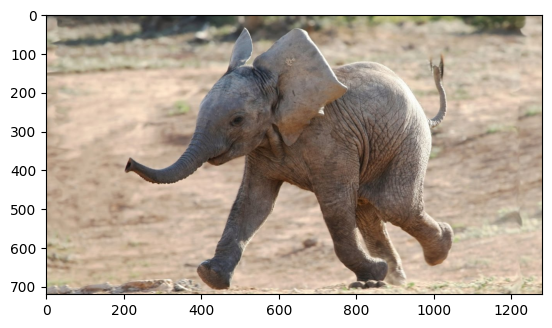

Indian_elephant, with probability: 49.23014831542969
tusker, with probability: 26.122406005859375
African_elephant, with probability: 18.051095962524414
triceratops, with probability: 3.6455471515655518
Mexican_hairless, with probability: 1.8485907316207886


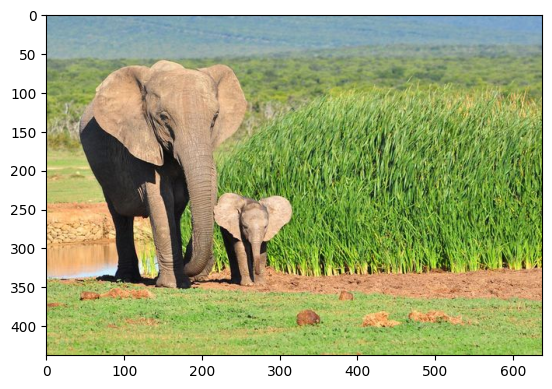

African_elephant, with probability: 90.69235229492188
tusker, with probability: 5.768009662628174
Indian_elephant, with probability: 3.5378570556640625
Arabian_camel, with probability: 0.0005144194583408535
zebra, with probability: 0.00035065942211076617


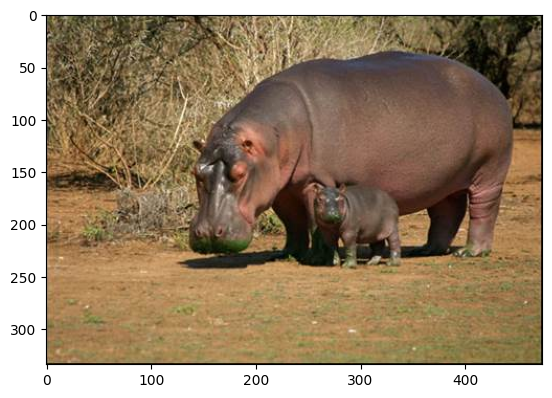

hippopotamus, with probability: 99.98188781738281
hog, with probability: 0.00885908491909504
Mexican_hairless, with probability: 0.004221335519105196
armadillo, with probability: 0.0018039653077721596
warthog, with probability: 0.0007287170155905187


In [36]:
from PIL import Image
import os

def load_img_preprocess(img_path):
    
    img = Image.open(img_path)

    x = Imagenet_transform(img)
    x = torch.unsqueeze(x, 0)
    return {"img": img, "x": x}

# modify the path according to your own file location
image_fold_path= "/kaggle/working/CNN_tutorial_data/images"

elephant1 = load_img_preprocess(os.path.join(image_fold_path,'elephant1.jpg'))
elephant2 = load_img_preprocess(os.path.join(image_fold_path,'elephant2.jpg'))
hippo1 = load_img_preprocess(os.path.join(image_fold_path,'hippo1.jpg'))

import matplotlib.pyplot as plt
def show_image_predictions(img_obj):
    plt.imshow(img_obj["img"])
    plt.show()
    
    model_ft.eval()
    out = model_ft(img_obj["x"])
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    _, indices = torch.sort(out, descending=True)
    for idx in indices[0][:5]:
        print ("{}, with probability: {}".format( idx2label[idx] ,  percentage[idx].item()))
        
show_image_predictions(elephant1)
show_image_predictions(elephant2)
show_image_predictions(hippo1)

# 3. Transfer Learning 

The basic premise of [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) is simple: take a model trained on a large dataset and transfer its knowledge to a smaller dataset. We usually freeze the early convolutional layers of the network and only train the last few layers which make a prediction. The idea is the convolutional layers extract general, low-level features that are applicable across images — such as edges, patterns, gradients — and the later layers identify specific features within an image such as eyes or wheels.


Thus, we  use the pre-train `Resnet-18` in section 2 and apply it to our own new task because there are universal, low-level features shared between images. Here we use MNIST as our new task

![avatar](https://miro.medium.com/max/638/1*ZkPBqU8vx2vAgcLpz9pi5g.jpeg)

This Resnet-18 model has over 33 million parameters, but we’ll train only the very last few fully-connected layers. Initially, we freeze all of the model’s weights:

In [40]:
for param in model_ft.parameters():   
    param.requires_grad = False

Resnet-18 is pre-trained in image net with 1000 categories, whereas MNIST has only 10. We need to modify the size of the last layer accordingly. 
Parameters of newly constructed modules have requires_grad=True by default.

In [41]:
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10..
model_ft.fc = nn.Linear(num_ftrs, 10)

Move model to GPU if appliable.

In [42]:
model_ft = model_ft.to(dev)

Print the parameters with `requires_grad=True`, so that double-check that only the last layer could be trained. 

In [43]:
for name, param in model_ft.named_parameters():
    if param.requires_grad:
          print(name)

fc.weight
fc.bias


The input image shape of resnet18 is `(3, 224, 224)`, whereas the image shape of MNIST dataset is `(1, 28, 28)`. We need `transforms` to preprocess our input data accordingly. 

In [44]:
Mnist_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
    ])

mnist_train = MNIST("2AMM10/", train=True, download=True, transform=Mnist_transform)
mnist_test = MNIST("2AMM10/", train=False, download=True, transform=Mnist_transform)


We define a little help function here to help us transfer data to GPU

In [45]:
def preprocess_gpu(x, y):
    return x.to(dev), y.to(dev)

train_dl, valid_dl = get_data(mnist_train, mnist_test, bs)
train_dl = WrappedDataLoader(train_dl, preprocess_gpu)
valid_dl = WrappedDataLoader(valid_dl, preprocess_gpu)

Train the model with `fit` funtion

In [ ]:
# this code might take a while to execute
lr = 0.1
opt = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)
epochs=10
loss_func = F.cross_entropy

fit(epochs, model_ft, loss_func, opt, train_dl, valid_dl)

  0%|          | 0/2 [00:00<?, ?it/s]